**MODELO 1: PREVISIÓN DE CANCELACIONES PARA GESTAMP**

In [65]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import re
# from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

Cargamos las tablas y hacemos un primer barrido de columnas inservibles. 

In [66]:
general = pd.read_csv("opportunities_general_data_202404261638.csv", sep = ',',on_bad_lines='skip', encoding='latin-1')
general_cleaned = general.drop(columns=['deletedBy', 'deletedOn', 'createdBy', 'modifiedBy', 'modifiedOn', 'investmentsComments', 'keySuccessFactors'])


In [67]:
sales = pd.read_csv("opportunities_sales_202404261640.csv", sep=',' ,  index_col=0, encoding='ISO-8859-1')
sales_cleaned = sales.drop(columns=['commercialStrategy','comments','awardedTo', 'awardedDate','createdBy', 'deletedBy','deletedOn', 'intercompany_ManagementCompany_code'])


In [68]:
cancellation_reasons = pd.read_csv("opportunity_sale_cancellation_reasons_202405021504.csv", sep=',')

In [69]:
general_cleaned["iD"] = general_cleaned.iD.apply(lambda x: str(x)).astype(str)
sales_cleaned["opportunityId"] = sales_cleaned.opportunityId.apply(lambda x: str(x).split(".")[0]).astype(str)


Mergeamos entre sales y general, haciendo un filtrado por saleStatus (nuestro target) = Cancelled y Awarded. sería interesante tener en cuenta sales_cancellations pero no tenemos registros coincidentes. Lanzaremos el modelo sin el cruce con dicha tabla y después volveremos a lanzar el modelo con el cruce de sales_cancellations.

In [70]:
general_cleaned["iD"] = general_cleaned.iD.apply(lambda x: str(x)).astype(str) #antes de la transformacion nos aseguramos que los ids estén en el mismo formato
sales_cleaned["opportunityId"] = sales_cleaned.opportunityId.apply(lambda x: str(x).split(".")[0]).astype(str)

sales_gen = pd.merge(sales_cleaned, general_cleaned, left_on="opportunityId", right_on="iD")
sales_gen.info()
#filtramos el cruce teniendo en cuenta solo ventas canceladas y ventas awarded, obviando las demás categorías
df = sales_gen[sales_gen['saleStatus'].isin(['Cancelled', 'Awarded'])] #total de 3107 filas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116 entries, 0 to 5115
Data columns (total 54 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   businessType                         5116 non-null   object 
 1   cancelDate                           1663 non-null   object 
 2   dateOnWhichTheRecordWasCreated_x     5116 non-null   object 
 3   currency                             5116 non-null   object 
 4   divisionStrategy                     5116 non-null   object 
 5   effectiveMonth                       2324 non-null   float64
 6   hasLTA                               5116 non-null   object 
 7   hasQuickSavings                      5116 non-null   object 
 8   Id                                   5116 non-null   float64
 9   inBusinessPlan                       5116 non-null   object 
 10  inBusinessPlanRevision               1796 non-null   object 
 11  inBusinessPlanYear            

*Reporte de variables*

¿Qué porcentaje de Nans tenemos? 
¿Cuántos valores únicos tenemos en cada columna? ¿Qué variables nos interesa quedarnos y cuales no?

In [9]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(df).T

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,object,0.0,2,0.06
cancelDate,object,46.48,396,12.75
dateOnWhichTheRecordWasCreated_x,object,0.0,1796,57.8
currency,object,0.0,10,0.32
divisionStrategy,object,0.0,4,0.13
effectiveMonth,float64,56.03,12,0.39
hasLTA,object,0.0,2,0.06
hasQuickSavings,object,0.0,2,0.06
Id,float64,0.0,3107,100.0


In [361]:
df["dateOnWhichTheRecordWasCreated_x"].value_counts()

dateOnWhichTheRecordWasCreated_x
2021-02-19 19:33:21.863    34
2021-02-19 19:33:21.330    33
2021-02-19 19:33:21.410    32
2021-02-19 19:33:21.677    32
2021-02-19 19:33:21.690    31
                           ..
2021-09-08 14:40:18.667     1
2021-09-08 14:39:05.277     1
2021-09-08 14:37:45.090     1
2021-09-08 14:36:24.877     1
2024-04-22 18:08:56.543     1
Name: count, Length: 1796, dtype: int64

**Feature Engineering 1**

In [71]:
df_copy = df.copy()

Antes de ninguna transformación, eliminamos las columnas que no necesitamos (nombres, códigos, Ids) o que contengan un porcentaje alto de Nans.

In [ ]:
#echar un ojo a inBusinessPlanRevision, turnoverSOP2, turnoverSOP2Euros, intercompany_ManagementCompany_desc,
# df_copy['turnoverSOP2'].unique() #fuera
# df_copy['turnoverSOP2Euros'].unique() #fuera
# df_copy['intercompany_ManagementCompany_desc'].unique() #nombres de las compañias, no nos interesa
# df_copy['hasInvestments'].unique() #es boleano, true 1 y 0 false
# df_copy['designResponsible'].unique() #es boleano, true 1 y 0 false
# df_copy['totalInvestmentCurrency'].unique() #esta podria entrar como nueva columna, quitar nans.
# df_copy['currency'].unique()
# df_copy['managementCompany_desc'].unique() #fuera
# df_copy['valueAdded'].unique() #fuera??
# df_copy['businessUnit_code'].unique() #fuera?? no sabemos qué son 1,2,3 @@@@@@@@@@@@@@PREGUNTAR!!!!!!!!!!!!!!
# df_copy['automotiveCompanyCode'].unique() #fuera
# df_copy['saleType'].unique() #codificar como 1 o 0 
# df_copy['opportunityStatus'].unique() #fuera
# df_copy['inBusinessPlanRevision'].unique() #fuera

In [72]:
# Columnas a eliminar
columns_to_drop = [
    'cancelDate', 'effectiveMonth', 'opportunity_desc', 'dateOnWhichTheRecordWasCreated_y',
    'opportunityId_y', 'versionID_y', 'lostDate', 'modifiedBy', 'modifiedOn', 
    'managementCompany_code', 'intercompany_ManagementCompany_desc', 'saleId', 'turnoverSOP2', 
    'turnoverSOP2Euros', 'versionID_x', 'divisionStrategy', 'iD', 'oEM_code', 
    'automotiveCompanyCode', 'opportunityYear', 'closingComments', 'opportunityId_x', 
    'managementCompany_desc', 'quickSavingsDiscountCurrency', 'expectedInitialRFQDate', 
    'strategicRelevance', 'lTAType', 'yearInvestmentStarted', 'closingDate', 'businessUnit_code',
    'inBusinessPlanYear', 'valueAdded', 'quickSavingsType', 'inBusinessPlanRevision','totalInvestmentCurrency', 'currency'
] 

df_copy = df_copy.drop(columns=columns_to_drop)

#conservaremos Id porque lo necesitamos para el segundo feature engineering, donde haremos un merge con nuestra tabla de cancelaciones

In [73]:
df_copy.columns

Index(['businessType', 'dateOnWhichTheRecordWasCreated_x', 'hasLTA',
       'hasQuickSavings', 'Id', 'inBusinessPlan', 'pricePerVehicle',
       'pricePerVehicleEuros', 'pricePerVehicleLocalCurrency', 'saleType',
       'saleStatus', 'annualAverageTotalPlanning', 'designResponsible',
       'expectedAwardDate', 'hasInvestments', 'probabilityOfAward',
       'opportunityStatus', 'automotiveCompanyName'],
      dtype='object')

In [74]:
data_report(df_copy).T

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,object,0.0,2,0.06
dateOnWhichTheRecordWasCreated_x,object,0.0,1796,57.8
hasLTA,object,0.0,2,0.06
hasQuickSavings,object,0.0,2,0.06
Id,float64,0.0,3107,100.0
inBusinessPlan,object,0.0,2,0.06
pricePerVehicle,float64,0.0,1699,54.68
pricePerVehicleEuros,float64,0.0,1755,56.49
pricePerVehicleLocalCurrency,float64,0.0,1844,59.35


Creamos una nueva columna: **time_delta_months** que sea la diferencia entre expectedAwardDate y dateOnWhichTheRecordWasCreated_x 

In [75]:
#Campos que necesitamos: dateOnWhichTheRecordWasCreated_x y expectedAwardDate (aplicaremos time delta para conocer el tiempo transcurrido)

# Limpiamos y preparamos el ID y opportunityId
# general_cleaned["iD"] = general_cleaned.iD.apply(lambda x: str(x)).astype(str)
# sales_cleaned["opportunityId"] = sales_cleaned.opportunityId.apply(lambda x: str(x).split(".")[0]).astype(str)

# Realizamos el join
# df = pd.merge(sales_cleaned, general_cleaned, left_on="opportunityId", right_on="iD")

# Extraemos y transformamos las fechas del formato trimestral
valid_dates = []
for date in df_copy['expectedAwardDate']:
    if re.match(r'Q[1-4]\d{4}', date):
        valid_dates.append(date)

valid_dates_df = pd.DataFrame(valid_dates, columns=['expectedAwardDate'])
valid_dates_df["date"] = pd.to_datetime(valid_dates_df["expectedAwardDate"].apply(
    lambda x: x.replace("Q1", "31-03-").replace("Q2", "30-06-").replace("Q3", "30-09-").replace("Q4", "31-12-")),
    format='%d-%m-%Y'
)

# Asignamos fechas convertidas de vuelta a sales_gen para alinear
df_copy = df_copy.assign(expectedAwardDate_converted=valid_dates_df['date'].values)

# Convertimos las fechas de creación a datetime si no lo están
df_copy["dateOnWhichTheRecordWasCreated_x"] = pd.to_datetime(df_copy["dateOnWhichTheRecordWasCreated_x"])

# Calculamos el delta de tiempo en meses
df_copy['time_delta_months'] = (df_copy['expectedAwardDate_converted'] - df_copy['dateOnWhichTheRecordWasCreated_x']) / pd.Timedelta(days=30)

# Preparar datos para el gráfico
# time_data = sales_gen[['dateOnWhichTheRecordWasCreated_x', 'time_delta_months']].dropna()
# time_data = time_data.sort_values(by='dateOnWhichTheRecordWasCreated_x')

In [76]:
data_report(df_copy).T

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,object,0.0,2,0.06
dateOnWhichTheRecordWasCreated_x,datetime64[ns],0.0,1796,57.8
hasLTA,object,0.0,2,0.06
hasQuickSavings,object,0.0,2,0.06
Id,float64,0.0,3107,100.0
inBusinessPlan,object,0.0,2,0.06
pricePerVehicle,float64,0.0,1699,54.68
pricePerVehicleEuros,float64,0.0,1755,56.49
pricePerVehicleLocalCurrency,float64,0.0,1844,59.35


Eliminamos las columnas de fecha que hemos usado para la creación de time_delta_months

In [77]:
columns_to_drop = [
    'expectedAwardDate','dateOnWhichTheRecordWasCreated_x', 'expectedAwardDate_converted'
] 
df_copy = df_copy.drop(columns=columns_to_drop)


In [78]:
data_report(df_copy).T #nos quedamos con 16 columnas limpias.

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,object,0.0,2,0.06
hasLTA,object,0.0,2,0.06
hasQuickSavings,object,0.0,2,0.06
Id,float64,0.0,3107,100.0
inBusinessPlan,object,0.0,2,0.06
pricePerVehicle,float64,0.0,1699,54.68
pricePerVehicleEuros,float64,0.0,1755,56.49
pricePerVehicleLocalCurrency,float64,0.0,1844,59.35
saleType,object,0.0,2,0.06


**Get Dummies**


In [79]:
categorical_columns = [
    'businessType', 'hasLTA', 'hasQuickSavings', 'inBusinessPlan', 
    'saleType', 'saleStatus', 'designResponsible', 'hasInvestments', 
    'opportunityStatus'
]

# Aplicar One Hot Encoding
df_encoded = pd.get_dummies(df_copy, columns=categorical_columns)
df_encoded.head()

,Id,pricePerVehicle,pricePerVehicleEuros,pricePerVehicleLocalCurrency,annualAverageTotalPlanning,probabilityOfAward,automotiveCompanyName,time_delta_months,businessType_Growth,businessType_Replacement,...,saleType_Intercompany,saleStatus_Awarded,saleStatus_Cancelled,designResponsible_False,designResponsible_True,hasInvestments_false,hasInvestments_true,opportunityStatus_Closed,opportunityStatus_Open,opportunityStatus_Pending Close
0,2097268.0,160.0,147.25,2685.66,0,75,Mercedes-Benz,19.572839,False,True,...,False,False,True,True,False,True,False,True,False,False
1,2097269.0,45.0,41.41,755.34,0,75,Mercedes-Benz,19.572839,False,True,...,True,False,True,True,False,True,False,True,False,False
2,2097270.0,120.0,110.44,2014.25,0,75,Mercedes-Benz,19.572839,False,True,...,False,False,True,True,False,True,False,True,False,False
3,2097271.0,35.0,32.21,587.49,0,75,Mercedes-Benz,19.572839,False,True,...,True,False,True,True,False,True,False,True,False,False
4,2097272.0,65.0,59.82,1091.05,0,75,Mercedes-Benz,19.572839,False,True,...,False,False,True,True,False,False,True,True,False,False


Transformación a valores numéricos...

In [80]:


# Mapeo de las variables categóricas a valores numéricos
mapping_dict = {
    'businessType': {'Replacement': 0, 'Growth': 1},
    'hasLTA': {'Yes': 1, 'No': 0},
    'hasQuickSavings': {'Yes': 1, 'No': 0},
    'inBusinessPlan': {'Yes': 1, 'No': 0},
    'saleType': {'External Sales': 0, 'Intercompany': 1},
    'saleStatus': {'Awarded': 0, 'Cancelled': 1},
    'designResponsible': {False: 0, True: 1},
    'hasInvestments': {'true': 1, 'false': 0},
    'opportunityStatus': {'Open': 0, 'Closed': 1, 'Pending Close': 2}
}

# Asignar valores numéricos según el mapeo
df_copy = df_copy.replace(mapping_dict)

# Mostrar las primeras filas del DataFrame transformado para verificación
df_copy.head()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_19540\3307569935.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy = df_copy.replace(mapping_dict)


,businessType,hasLTA,hasQuickSavings,Id,inBusinessPlan,pricePerVehicle,pricePerVehicleEuros,pricePerVehicleLocalCurrency,saleType,saleStatus,annualAverageTotalPlanning,designResponsible,hasInvestments,probabilityOfAward,opportunityStatus,automotiveCompanyName,time_delta_months
0,0,1,1,2097268.0,1,160.0,147.25,2685.66,0,1,0,0,0,75,1,Mercedes-Benz,19.572839
1,0,1,1,2097269.0,1,45.0,41.41,755.34,1,1,0,0,0,75,1,Mercedes-Benz,19.572839
2,0,1,1,2097270.0,1,120.0,110.44,2014.25,0,1,0,0,0,75,1,Mercedes-Benz,19.572839
3,0,1,1,2097271.0,1,35.0,32.21,587.49,1,1,0,0,0,75,1,Mercedes-Benz,19.572839
4,0,0,0,2097272.0,1,65.0,59.82,1091.05,0,1,0,0,1,75,1,Mercedes-Benz,19.572839


Otro cambio que queremos implementar para esta primera version de nuestro df será aplicar get_dummies en nuestras columnas de clientes. Nos quedaremos con una columna por cada cliente (solo aquellos que más trabajan con Gestamp). El resto de los clientes se englobará en una columna "otros". Eliminamos automotiveCompanyName.

In [81]:
df_copy["automotiveCompanyName"].value_counts()

automotiveCompanyName
STELLANTIS           724
Volkswagen           690
Renault/Nissan       377
Tata-JLR             257
Ford                 173
Mercedes-Benz        166
Toyota               145
BMW                  116
General Motors        92
Geely-Volvo           91
Hyundai               43
Honda                 32
Tesla                 31
Mahindra              23
Ineos                 22
AvtoVAZ               12
Volvo Truck & Bus      9
Saic                   9
Webasto                8
Mazda                  7
BYD                    7
Rivian                 7
Arrival                6
Guangzhou Auto         6
Mi Auto                6
Daimler Truck          6
Great Wall             4
Vinfast                3
Marelli                3
Changan                3
LI AUTO                3
Suzuki                 3
Evergrande             2
Samsung                2
Subaru                 2
OLA                    2
KG MOBILITY            1
Envision               1
Valeo Kapec            1
Con

In [82]:
# Definir las compañías más populares
popular_companies = [
    'STELLANTIS', 'Volkswagen', 'Renault/Nissan', 'Tata-JLR', 
    'Ford', 'Mercedes-Benz', 'Toyota', 'BMW'
]

# Crear columnas para las compañías populares y una columna para "otros"
for company in popular_companies:
    df_copy[company] = df_copy['automotiveCompanyName'].apply(lambda x: 1 if x == company else 0)

# Crear la columna "otros"
df_copy['Otros'] = df_copy['automotiveCompanyName'].apply(lambda x: 0 if x in popular_companies else 1)


In [83]:
columns_to_drop = [
    'automotiveCompanyName'
] 
df_copy = df_copy.drop(columns=columns_to_drop)

In [84]:
df_copy.columns

Index(['businessType', 'hasLTA', 'hasQuickSavings', 'Id', 'inBusinessPlan',
       'pricePerVehicle', 'pricePerVehicleEuros',
       'pricePerVehicleLocalCurrency', 'saleType', 'saleStatus',
       'annualAverageTotalPlanning', 'designResponsible', 'hasInvestments',
       'probabilityOfAward', 'opportunityStatus', 'time_delta_months',
       'STELLANTIS', 'Volkswagen', 'Renault/Nissan', 'Tata-JLR', 'Ford',
       'Mercedes-Benz', 'Toyota', 'BMW', 'Otros'],
      dtype='object')

In [85]:
data_report(df_copy).T #el df con el que lanzaremos nuestro primer modelo


,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
businessType,int64,0.0,2,0.06
hasLTA,int64,0.0,2,0.06
hasQuickSavings,int64,0.0,2,0.06
Id,float64,0.0,3107,100.0
inBusinessPlan,int64,0.0,2,0.06
pricePerVehicle,float64,0.0,1699,54.68
pricePerVehicleEuros,float64,0.0,1755,56.49
pricePerVehicleLocalCurrency,float64,0.0,1844,59.35
saleType,int64,0.0,2,0.06


In [86]:
df_copy.to_csv('df_copy1_onehot.csv', index=False)

In [87]:
df_copy.columns

Index(['businessType', 'hasLTA', 'hasQuickSavings', 'Id', 'inBusinessPlan',
       'pricePerVehicle', 'pricePerVehicleEuros',
       'pricePerVehicleLocalCurrency', 'saleType', 'saleStatus',
       'annualAverageTotalPlanning', 'designResponsible', 'hasInvestments',
       'probabilityOfAward', 'opportunityStatus', 'time_delta_months',
       'STELLANTIS', 'Volkswagen', 'Renault/Nissan', 'Tata-JLR', 'Ford',
       'Mercedes-Benz', 'Toyota', 'BMW', 'Otros'],
      dtype='object')

In [88]:
df_copy

,businessType,hasLTA,hasQuickSavings,Id,inBusinessPlan,pricePerVehicle,pricePerVehicleEuros,pricePerVehicleLocalCurrency,saleType,saleStatus,...,time_delta_months,STELLANTIS,Volkswagen,Renault/Nissan,Tata-JLR,Ford,Mercedes-Benz,Toyota,BMW,Otros
0,0,1,1,2097268.0,1,160.0,147.25,2685.66,0,1,...,19.572839,0,0,0,0,0,1,0,0,0
1,0,1,1,2097269.0,1,45.0,41.41,755.34,1,1,...,19.572839,0,0,0,0,0,1,0,0,0
2,0,1,1,2097270.0,1,120.0,110.44,2014.25,0,1,...,19.572839,0,0,0,0,0,1,0,0,0
3,0,1,1,2097271.0,1,35.0,32.21,587.49,1,1,...,19.572839,0,0,0,0,0,1,0,0,0
4,0,0,0,2097272.0,1,65.0,59.82,1091.05,0,1,...,19.572839,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5040,1,1,1,2102313.0,0,20.0,2.56,20.00,0,1,...,5.783087,0,0,0,0,0,0,0,1,0
5041,1,1,0,2102314.0,0,105.0,96.63,1762.47,0,1,...,8.844552,0,0,1,0,0,0,0,0,0
5059,1,0,0,2102332.0,0,50.0,50.00,1742.44,0,1,...,2.456871,0,1,0,0,0,0,0,0,0
5085,1,0,0,2102358.0,0,40.0,36.81,40.00,0,1,...,5.487962,0,0,0,0,0,0,0,0,1


Ya tenemos nuestro dataset limpio. Veamos la distribución de nuestras variables... Comprobemos cómo de desbalanceada está nuestro target

In [90]:
target_clf = "saleStatus"

**Matriz de correlación**

<Axes: >

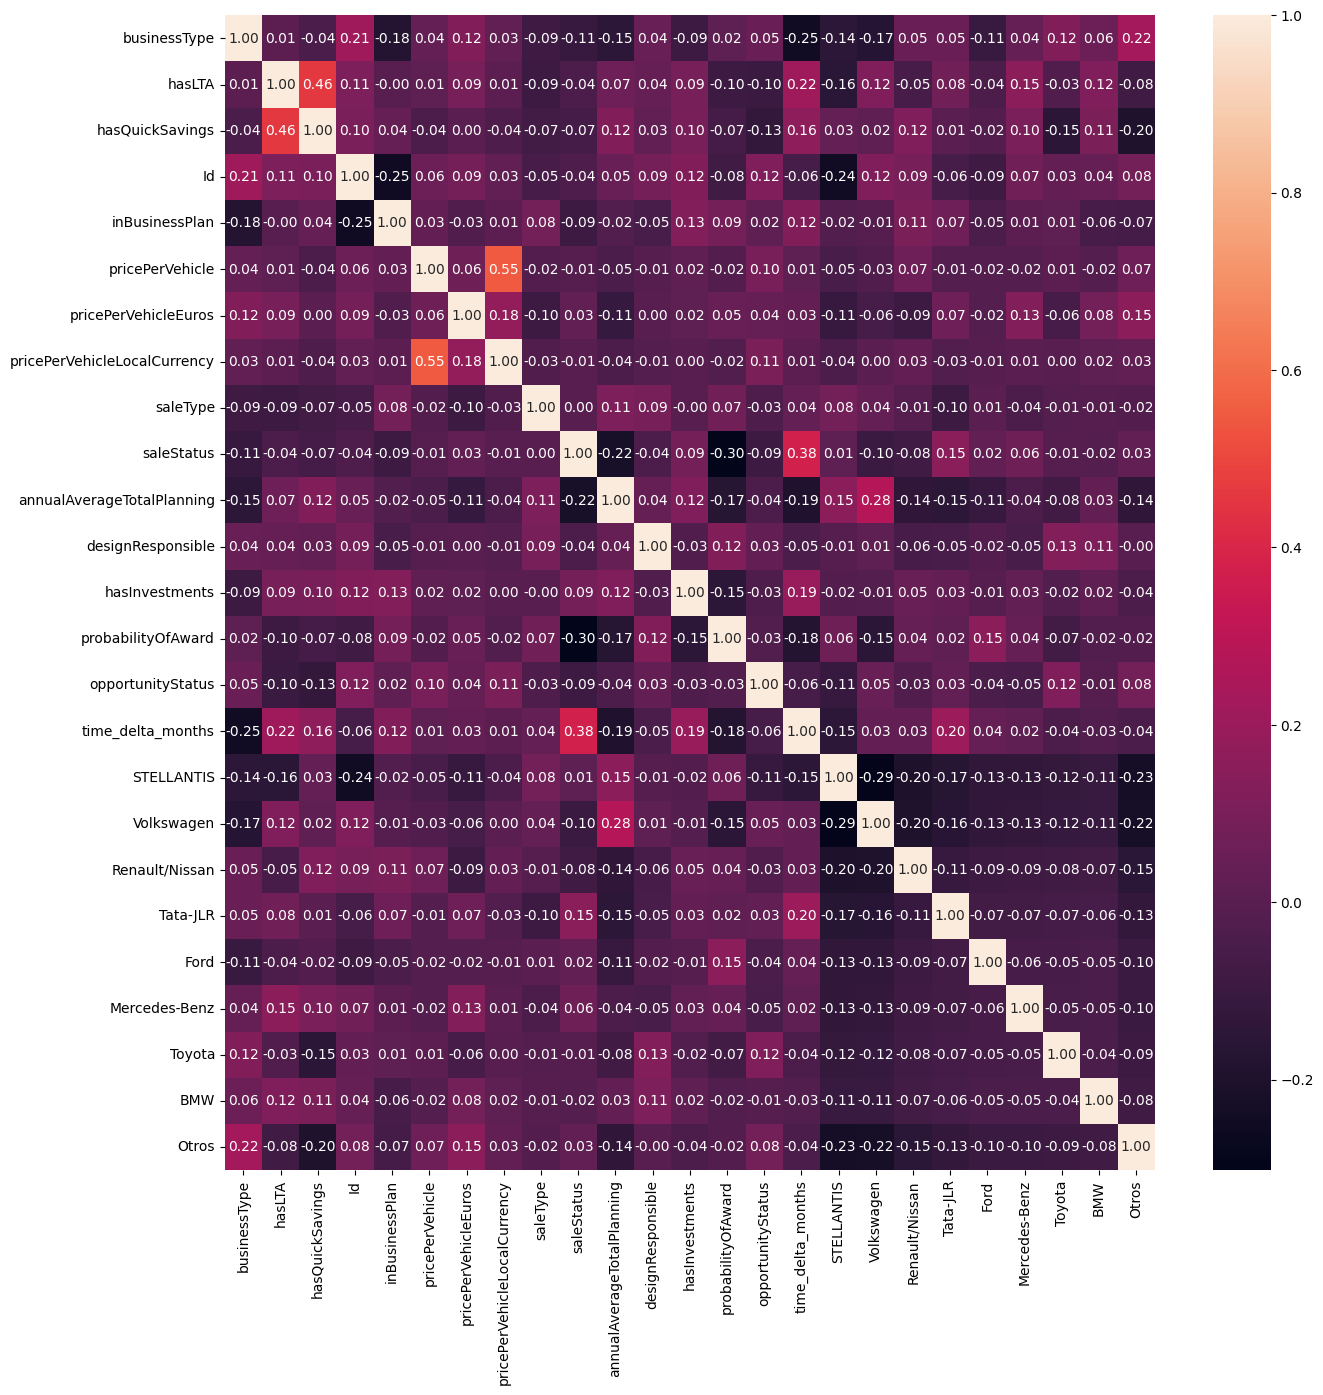

In [379]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_copy.corr(), annot=True, fmt='.2f')

Del gráfico podemos concluir que:
- `time_delta_months` es la variable que más correla con nuestro target `saleStatus`
- `pricePervehicleEuros` y `pricePervehicle` tienen correlación, eliminaremos pricePervehicleEuros
- `HasLTA` y `hasQuickSavings` tienen correlación, eliminamos hasQuickSavings

Eliminamos las columnas que correlan entre ellas y menos correlan con nuestro target.

In [89]:
columns_to_drop = [
    'pricePerVehicleEuros', 'hasQuickSavings', 'pricePerVehicleLocalCurrency'
] 

df_copy = df_copy.drop(columns=columns_to_drop)

In [90]:
df_copy.columns

Index(['businessType', 'hasLTA', 'Id', 'inBusinessPlan', 'pricePerVehicle',
       'saleType', 'saleStatus', 'annualAverageTotalPlanning',
       'designResponsible', 'hasInvestments', 'probabilityOfAward',
       'opportunityStatus', 'time_delta_months', 'STELLANTIS', 'Volkswagen',
       'Renault/Nissan', 'Tata-JLR', 'Ford', 'Mercedes-Benz', 'Toyota', 'BMW',
       'Otros'],
      dtype='object')

**Normalización**

In [91]:
df_copy.describe() #podemos utilizar MinMaxScaler de scikit-learn, que transformará los datos a un rango entre 0 y 1

,businessType,hasLTA,Id,inBusinessPlan,pricePerVehicle,saleType,saleStatus,annualAverageTotalPlanning,designResponsible,hasInvestments,...,time_delta_months,STELLANTIS,Volkswagen,Renault/Nissan,Tata-JLR,Ford,Mercedes-Benz,Toyota,BMW,Otros
count,3107.000000,3107.000000,3.107000e+03,3107.000000,3107.000000,3107.000000,3107.000000,3.107000e+03,3107.000000,3107.000000,...,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000
mean,0.626971,0.439652,2.099505e+06,0.497264,1079.077010,0.095591,0.535243,1.404746e+05,0.091407,0.912456,...,12.424948,0.233022,0.222079,0.121339,0.082716,0.055681,0.053428,0.046669,0.037335,0.147731
std,0.483687,0.496425,1.408925e+03,0.500073,10561.498255,0.294076,0.498837,1.931349e+05,0.288233,0.282676,...,12.650596,0.422824,0.415711,0.326573,0.275497,0.229341,0.224921,0.210962,0.189612,0.354890
min,0.000000,0.000000,2.097268e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,-23.060495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.098232e+06,0.000000,8.000000,0.000000,0.000000,1.795700e+04,0.000000,1.000000,...,4.259508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.099431e+06,0.000000,42.000000,0.000000,1.000000,7.059900e+04,0.000000,1.000000,...,10.472839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,2.100696e+06,1.000000,200.000000,0.000000,1.000000,1.803930e+05,0.000000,1.000000,...,20.551775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,2.102385e+06,1.000000,336809.000000,1.000000,1.000000,1.321008e+06,1.000000,1.000000,...,65.206172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


El proceso de normalización debe estar basado únicamente en los datos de entrenamiento para evitar cualquier tipo de información del conjunto de prueba durante el entrenamiento del modelo. Hacemos un train test split antes.

**¿Cómo aplico el escalado a train y test?**. 

Primero creo los objetos scaler con los datos de train (SOLO los de train), y aplica ese scaler tanto a train como a test. Así no contamino el conjunto de train con los datos de test.

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_copy.drop('saleStatus', axis=1)  # Suponiendo que 'saleStatus' es la variable objetivo
y = df_copy['saleStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el MinMaxScaler
scaler = MinMaxScaler()

# Ajustar el scaler solo con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Convertir los datos escalados a DataFrames si se desea
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


print(X_train_scaled.describe())
print(X_test_scaled.describe())


       businessType       hasLTA           Id  inBusinessPlan  \
count   2174.000000  2174.000000  2174.000000     2174.000000   
mean       0.631095     0.432383     0.443578        0.491260   
std        0.482619     0.495521     0.275474        0.500039   
min        0.000000     0.000000     0.000000        0.000000   
25%        0.000000     0.000000     0.196404        0.000000   
50%        1.000000     0.000000     0.430242        0.000000   
75%        1.000000     1.000000     0.674150        1.000000   
max        1.000000     1.000000     1.000000        1.000000   

       pricePerVehicle     saleType  annualAverageTotalPlanning  \
count      2174.000000  2174.000000                 2174.000000   
mean          0.007426     0.095676                    0.118808   
std           0.038668     0.294214                    0.165639   
min           0.000000     0.000000                    0.000000   
25%           0.000078     0.000000                    0.015194   
50%         

In [93]:
X.shape,y.shape

((3107, 21), (3107,))

Antes de investigar modelos más complicados, lanzaremos un logisticRegressor como baseline para comparar con los siguientes modelos más complejos. (Por ser un modelo rápido y sencillo de implementar)

In [94]:
# Metricas de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report

# Crear y entrenar el modelo de Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = logistic_model.predict(X_test)

# Evaluar el rendimiento del modelo
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.59      0.66       444
           1       0.69      0.81      0.75       489

    accuracy                           0.71       933
   macro avg       0.72      0.70      0.70       933
weighted avg       0.71      0.71      0.70       933



c:\Users\Usuario\.conda\envs\ML-ENV\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
print(accuracy_score(y_test, y_pred)) #veamos cómo podemos mejorar nuestro accuracy

0.7084673097534834


In [96]:
from sklearn.metrics import accuracy_score

# Calcular el puntaje de precisión (accuracy)
acierto = accuracy_score(y_test, y_pred)

# Calcular el error
error = 1 - acierto

print("Acierto:", round(acierto * 100, 2), "%")
print("Error:", round(error * 100, 2), "%")


Acierto: 70.85 %
Error: 29.15 %


El modelo actual tiene un rendimiento razonable con una precisión del 71%. nos equivocamos en un 29%. 

Este modelo nos sirve como línea base para comparar con otros modelos más complejos y buscar mejoras adicionales en el rendimiento.

**Comparación con otros modelos clasificación** 

-Evaluación del Mejor Modelo:
Este enfoque nos permite comparar de manera sistemática varios modelos de clasificación y seleccionar el más óptimo para nuestro caso de uso

Lanzamos modelos de árboles sin optimizar, el que mejor resultado nos dé es el que optimizaremos.

In [97]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle

In [98]:
pipe = Pipeline(steps=[
    ('classifier', LinearRegression())
])

logistic_params = {
    'classifier': [LogisticRegression()],
}

random_forest_params = {
    'classifier': [RandomForestClassifier()],
}
extra_trees = {
    'classifier': [ExtraTreesClassifier()],
}

ada_param = {
    'classifier': [AdaBoostClassifier()],
}

gbc_param = {
    'classifier': [GradientBoostingClassifier()],
}

xgb_param = {
    'classifier': [XGBClassifier()],
}

KNC_param = {
    'classifier': [KNeighborsClassifier()],
}

search_space = [
    logistic_params,
    random_forest_params,
    extra_trees,
    ada_param,
    gbc_param,
    xgb_param,
    KNC_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  n_jobs= -1,
                  cv = 10)

clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()]},
                         {'classifier': [RandomForestClassifier()]},
                         {'classifier': [ExtraTreesClassifier()]},
                         {'classifier': [AdaBoostClassifier()]},
                         {'classifier': [GradientBoostingClassifier()]},
                         {'classifier': [XGBClassifier(base_score=Non...
                                                       interaction_constraints=None,
                                                       learning_rate=None,
                                                       max_bin=None,
                                                       max_cat_threshold=None,
                                                       max_cat_to_onehot=None,
                                                       max_delta_step=None,
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...)]},
                         {'classifier': [KNeighborsClassifier()]}])

In [99]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('classifier', RandomForestClassifier())])
0.8744472159979706
{'classifier': RandomForestClassifier()}


In [ ]:
# Nuestro accuracy ha aumentado considerablemente con respecto al modelo baseline. 

Optimizamos el modelo que mejor accuracy nos da.

In [100]:
random_forest = RandomForestClassifier()

params = {"n_estimators": [50, 100, 150, 200, 300],
          "max_depth": [5,7,9],
          "random_state": [42]}

random_forest = GridSearchCV(estimator=random_forest,
                      param_grid=params,
                      n_jobs=-1,
                      cv=10,
                      scoring="f1")

random_forest.fit(X_train_scaled, y_train)
random_forest.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=300, random_state=42)

In [101]:
random_f=RandomForestClassifier(max_depth=9,n_estimators=300,random_state=42)
random_f.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=9, n_estimators=300, random_state=42)

In [102]:
predictions = random_f.predict(X_test_scaled)
rf_score= f1_score(y_test,predictions)
rf_acc= accuracy_score(y_test,predictions)
print(f"Score de Random Forest modelo 1: {rf_score}")
print(f"Accuracy de Random Forest modelo 1: {rf_acc}")

Score de Random Forest modelo 1: 0.8773388773388774
Accuracy de Random Forest modelo 1: 0.8735262593783494


In [103]:
feature_importances= random_f.feature_importances_
feature_importances

array([0.02176475, 0.02362404, 0.15496723, 0.03633777, 0.08954032,
       0.00655154, 0.23400344, 0.00904435, 0.00634932, 0.10818391,
       0.02498435, 0.20576468, 0.00889184, 0.01484085, 0.01682725,
       0.0145881 , 0.00386522, 0.00552146, 0.00336829, 0.00365686,
       0.00732442])

In [63]:
X.columns

Index(['businessType', 'hasLTA', 'inBusinessPlan', 'pricePerVehicle',
       'saleType', 'annualAverageTotalPlanning', 'designResponsible',
       'hasInvestments', 'probabilityOfAward', 'opportunityStatus',
       'time_delta_months', 'STELLANTIS', 'Volkswagen', 'Renault/Nissan',
       'Tata-JLR', 'Ford', 'Mercedes-Benz', 'Toyota', 'BMW', 'Otros'],
      dtype='object')

In [104]:
feature_importance_df = pd.DataFrame({'Columna': X.columns, 'Importancia': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False).reset_index()
# feature_importance_df = feature_importance_df.drop('index',axis=1)
feature_importance_df

,index,Columna,Importancia
0,6,annualAverageTotalPlanning,0.234003
1,11,time_delta_months,0.205765
2,2,Id,0.154967
3,9,probabilityOfAward,0.108184
4,4,pricePerVehicle,0.089540
5,3,inBusinessPlan,0.036338
6,10,opportunityStatus,0.024984
7,1,hasLTA,0.023624
8,0,businessType,0.021765
9,14,Renault/Nissan,0.016827


In [106]:
import pandas as pd

# DataFrame inicial con todas las columnas
feature_importance_df = pd.DataFrame({
    'Columna': [
        'annualAverageTotalPlanning', 'time_delta_months', 'Id', 'probabilityOfAward', 
        'pricePerVehicle', 'inBusinessPlan', 'opportunityStatus', 'hasLTA', 'businessType', 
        'Renault/Nissan', 'Volkswagen', 'Tata-JLR', 'designResponsible', 'STELLANTIS', 'Otros', 
        'saleType', 'hasInvestments', 'Mercedes-Benz', 'Ford', 'BMW', 'Toyota'
    ],
    'Importancia': [
        0.234003, 0.205765, 0.154967, 0.108184, 0.089540, 0.036338, 0.024984, 0.023624, 
        0.021765, 0.016827, 0.014841, 0.014588, 0.009044, 0.008892, 0.007324, 0.006552, 
        0.006349, 0.005521, 0.003865, 0.003657, 0.003368
    ]
})

# Eliminando la fila donde 'Columna' es 'Id'
feature_importance_df = feature_importance_df[feature_importance_df['Columna'] != 'Id'].reset_index(drop=True)

# Mostrando el DataFrame resultante
feature_importance_df

,Columna,Importancia
0,annualAverageTotalPlanning,0.234003
1,time_delta_months,0.205765
2,probabilityOfAward,0.108184
3,pricePerVehicle,0.089540
4,inBusinessPlan,0.036338
5,opportunityStatus,0.024984
6,hasLTA,0.023624
7,businessType,0.021765
8,Renault/Nissan,0.016827
9,Volkswagen,0.014841


In [ ]:
#sacar métricas y matriz de confusion (accuracy, )

**Elegir hiperparámetros**

In [104]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt
# import seaborn as sns

# # # Supongamos que 'df' es tu DataFrame original y 'saleStatus' es la variable objetivo
# # X = df.drop('saleStatus', axis=1)  # Características
# # y = df['saleStatus']               # Variable objetivo

# # # Dividir los datos en conjuntos de entrenamiento y prueba
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Crear el pipeline con el MinMaxScaler y un placeholder para el modelo
# pipeline = Pipeline([
#     ('scaler', MinMaxScaler()),  # Normalización
#     ('classifier', DecisionTreeClassifier())  # Modelo placeholder
# ])

# # Definir los modelos y los hiperparámetros para GridSearchCV
# param_grid = [
#     {
#         'classifier': [DecisionTreeClassifier()],
#         'classifier__max_depth': list(range(1, 20)),
#         'classifier__min_samples_split': [2, 5, 10],
#         'classifier__min_samples_leaf': [1, 2, 4]
#     },
#     {
#         'classifier': [RandomForestClassifier()],
#         'classifier__n_estimators': [100, 200, 300],
#         'classifier__max_depth': [None, 10, 20, 30],
#         'classifier__min_samples_split': [2, 5, 10],
#         'classifier__min_samples_leaf': [1, 2, 4],
#         'classifier__max_features': ['sqrt', 'log2']
#     },
#     {
#         'classifier': [GradientBoostingClassifier()],
#         'classifier__n_estimators': [100, 200, 300],
#         'classifier__learning_rate': [0.01, 0.1, 0.2],
#         'classifier__max_depth': [3, 4, 5],
#         'classifier__min_samples_split': [2, 5, 10],
#         'classifier__min_samples_leaf': [1, 2, 4]
#     },
#     {
#         'classifier': [AdaBoostClassifier()],
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.01, 0.1, 1.0]
#     },
#     {
#         'classifier': [XGBClassifier()],
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.01, 0.1, 0.2],
#         'classifier__max_depth': [3, 4, 5],
#         'classifier__min_child_weight': [1, 3, 5]
#     },
#     {
#         'classifier': [ExtraTreesClassifier()],
#         'classifier__n_estimators': [100, 200, 300],
#         'classifier__max_depth': [None, 10, 20, 30],
#         'classifier__min_samples_split': [2, 5, 10],
#         'classifier__min_samples_leaf': [1, 2, 4],
#         'classifier__max_features': ['sqrt', 'log2']
#     }
# ]

# # Crear y configurar GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# # Entrenar el modelo con GridSearchCV
# grid_search.fit(X_train, y_train)

# # Obtener los mejores parámetros y el mejor modelo
# best_model = grid_search.best_estimator_
# print("Best parameters found: ", grid_search.best_params_)



Fitting 5 folds for each of 936 candidates, totalling 4680 fits
Best parameters found:  {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


              precision    recall  f1-score   support

           0       0.86      0.88      0.87       444
           1       0.89      0.87      0.88       489

    accuracy                           0.88       933
   macro avg       0.88      0.88      0.88       933
weighted avg       0.88      0.88      0.88       933

Acierto: 87.78 %
Error: 12.22 %


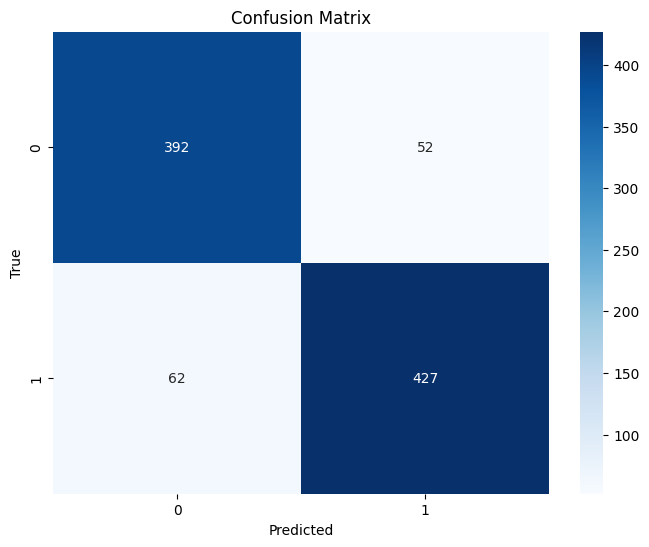

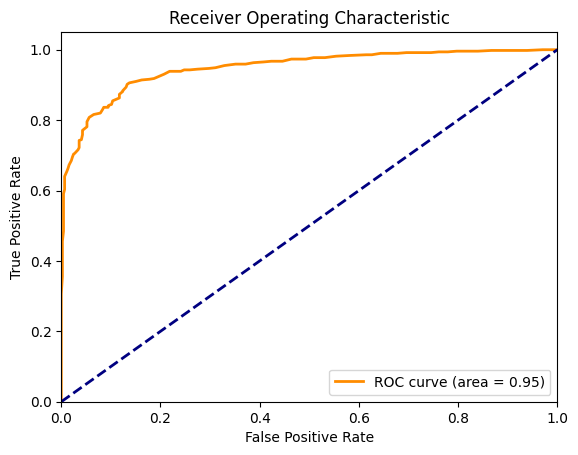

In [105]:
# # Evaluar el modelo en el conjunto de prueba
# y_pred = best_model.predict(X_test)
# print(classification_report(y_test, y_pred))

# # Calcular la precisión y el error
# acierto = accuracy_score(y_test, y_pred)
# error = 1 - acierto
# print("Acierto:", round(acierto * 100, 2), "%")
# print("Error:", round(error * 100, 2), "%")

# # Matriz de confusión
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Curva ROC y AUC
# if hasattr(best_model, "predict_proba"):
#     y_prob = best_model.predict_proba(X_test)[:, 1]
# else:
#     y_prob = best_model.decision_function(X_test)

# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# roc_auc = roc_auc_score(y_test, y_prob)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()
